#### Libraries importeren

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt

#### Set seed

In [96]:
np.random.seed(42)
torch.manual_seed(42)

#### Dataset inladen en inzien
Voordat ik de data volledig ga transformeren, wil ik eerst het gemiddelde en de standaardafwijking weten voor de normalisatie. Daarnaast wil ik ook weten wat de grote van de afbeelding is qua pixels en het kanaal (grijstinten of rgb).

In [97]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

alle_afbeeldingen = torch.cat([image.unsqueeze(0) 
                               for image, _ in train_data], dim=0)

print(f"Gemiddelde: {alle_afbeeldingen.mean().item():.4f}, Standaardafwijking: {alle_afbeeldingen.std().item():.4f}")

Gemiddelde: 0.1307, Standaardafwijking: 0.3081


In [98]:
image, label = train_data[0]
print(f"Afbeelding formaat: {image.shape}")

Afbeelding formaat: torch.Size([1, 28, 28])


#### Data transformeren

In [99]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), #Afbeelding bevat grijstinten (kan je zien door de 1 in het formaat)
    transforms.Resize((28, 28)), #Juiste afmetingen invoeren 
    transforms.RandomRotation(10),  #Willekeurige rotaties tot 10 graden
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) #Normalisatie op basis van het gem en standaardafwijking
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

#### Architectuur van CNN bouwen

In [100]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    
    nn.Linear(128 * 3 * 3, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(256, 10)
)

#### Check voor GPU
I.v.m. dat het model zwaar kan zijn, check ik eerst ff of het huidige apparaat een GPU heeft. Dit kan het trainen een stuk versneller namelijk.

In [101]:
component = torch.device("cuda" if torch.cuda.is_available()
                         else "cpu")
model = model.to(component)
print(f"Model runt op {component}")

Model runt op cuda


#### Model trainen

In [102]:
optimalisator = optim.Adam(model.parameters(), lr=0.0001)
criterium = nn.CrossEntropyLoss()

In [103]:
epochs = 10
for epoch in range(epochs):
    model.train()
    totale_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(component), labels.to(component) #Runt het model op geschikte component
        
        optimalisator.zero_grad()
        output = model(images)
        loss = criterium(output, labels)
        loss.backward()
        optimalisator.step()
        totale_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {totale_loss / len(train_loader)}")

torch.save(model.state_dict(), "Getrainde_modellen/CNN_Model_gewichten.pth")

Epoch 1, Loss: 0.3390952971722208
Epoch 2, Loss: 0.08600570275080896
Epoch 3, Loss: 0.06335012835643089
Epoch 4, Loss: 0.05296974334079447
Epoch 5, Loss: 0.04570632657931764
Epoch 6, Loss: 0.040967410152925966
Epoch 7, Loss: 0.03627166679121061
Epoch 8, Loss: 0.031550747600680926
Epoch 9, Loss: 0.028079723856207838
Epoch 10, Loss: 0.0262742018017338


#### Laad getrainde model indien nodig (voor apparaten zonder cuda bijvoorbeeld)

In [104]:
model.load_state_dict(torch.load("Getrainde_modellen/CNN_Model_gewichten.pth", 
                                 map_location=torch.device(component)))


<All keys matched successfully>

#### Evaluatie van model

In [105]:
model.eval()
with torch.no_grad():
    correct_voorspeld = 0
    totaal_voorspeld = 0
    for images, labels in test_loader:
        images, labels = images.to(component), labels.to(component)
        test_output = model(images)
        _, predicted = torch.max(test_output, 1)
        correct_voorspeld += (predicted == labels).sum().item()
        totaal_voorspeld += labels.size(0)

accuratie = correct_voorspeld / totaal_voorspeld * 100

print("Werkelijke labels:", labels[:16].tolist())  
print("Voorspelde labels:", predicted[:16].tolist()) 
print(f"Accuratie na training: {accuratie:.2f}%")

Werkelijke labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Voorspelde labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6]
Accuratie na training: 99.17%


#### Nieuwe data inladen en inspecteren

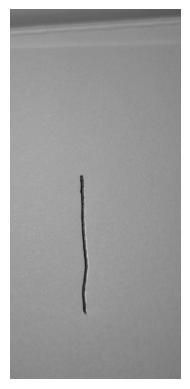

In [106]:
Nummer1 = Image.open("Afbeeldingen/Nummer1.jpg").convert("L")
Nummer3 = Image.open("Afbeeldingen/Nummer3.jpg").convert("L").rotate(-90)
Nummer5 = Image.open("Afbeeldingen/Nummer5.jpg").convert("L").rotate(-90)

transform = transforms.ToTensor()
Nummer1 = transform(Nummer1)
Nummer1 = Nummer1.squeeze().numpy()

plt.imshow(Nummer1, cmap='gray')
plt.axis('off')
plt.show()

#### Nieuwe data transformeren

In [108]:
Nummer1 = Image.open("Afbeeldingen/Nummer1.jpg").convert("L")
Nummer3 = Image.open("Afbeeldingen/Nummer3.jpg").convert("L").rotate(-90)
Nummer5 = Image.open("Afbeeldingen/Nummer5.jpg").convert("L").rotate(-90)

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1 - x), #Draait de kleuren om
    transforms.Normalize((0.1307,), (0.3081,))
])
Nummer3 = transform(Nummer3).unsqueeze(0).to(component)

#### Nieuwe data introduceren in CNN

In [110]:
model.eval()
with torch.no_grad():
    test_output = model(Nummer3)
    zekerheidsgraad = torch.softmax(test_output, dim=1)
    voorspelling = torch.argmax(zekerheidsgraad, 1).item()
    zekerheid = zekerheidsgraad[0][voorspelling].item()
    
    print(f"Het model denkt dat dit cijfer een {voorspelling} is met een zekerheidsgraad van {zekerheid:.4f}!")


Het model denkt dat dit cijfer een 8 is met een zekerheidsgraad van 0.4672!
